In [1]:
from typing import Callable, Iterator, Sequence
from tqdm import tqdm
import functools

import os
import numpy as np
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex

## Dataset loading

In [2]:
data_dir = 'dataset'
X_train = np.load(os.path.join(data_dir, 'X_train_checkerboard.npy'))
X_test = np.load(os.path.join(data_dir, 'X_test_checkerboard.npy'))
# X_train = np.load(os.path.join(data_dir, 'X_train_gaussian_mixture.npy'))
# X_test = np.load(os.path.join(data_dir, 'X_test_gaussian_mixture.npy'))
# X_train = np.load(os.path.join(data_dir, 'X_train_spiral.npy'))
# X_test = np.load(os.path.join(data_dir, 'X_test_spiral.npy'))
# X_train = np.load(os.path.join(data_dir, 'X_train_pinwheel.npy'))
# X_test = np.load(os.path.join(data_dir, 'X_test_pinwheel.npy'))

## Define MLP encoder and decoder

In [3]:
Activation = Callable[[jax.Array], jax.Array]
latent_dim = 10

class Encoder(nn.Module):
    features: Sequence[int]  # Number of neurons in each layer
    latent_dim: int
    activation: Activation = nn.relu

    @nn.compact
    def __call__(self, x: jax.Array) -> jax.Array:
        for f in self.features:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        mean = nn.Dense(self.latent_dim)(x)
        log_var = nn.Dense(self.latent_dim)(x)
        return mean, log_var
    
encoder = Encoder(features=[64, 64], latent_dim=latent_dim)
print(encoder.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))

2024-04-23 22:57:11.241172: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.



                                Encoder Summary                                 
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs        ┃ outputs         ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Encoder │ float32[1,2]  │ - float32[1,10] │                        │
│         │         │               │ - float32[1,10] │                        │
├─────────┼─────────┼───────────────┼─────────────────┼────────────────────────┤
│ Dense_0 │ Dense   │ float32[1,2]  │ float32[1,64]   │ bias: float32[64]      │
│         │         │               │                 │ kernel: float32[2,64]  │
│         │         │               │                 │                        │
│         │         │               │                 │ 192 (768 B)            │
├─────────┼─────────┼───────────────┼─────────────────┼────────────────────────┤
│ Dense_1 │ Dense   │ float

In [4]:
class Decoder(nn.Module):
    features: Sequence[int]  # Number of neurons in each layer
    output_dim: int
    activation: Activation = nn.relu

    @nn.compact
    def __call__(self, z: jax.Array) -> jax.Array:
        for f in self.features:
            z = nn.Dense(f)(z)
            z = self.activation(z)
        x_recon = nn.Dense(self.output_dim)(z)
        # x_recon = self.activation(x_recon)
        return x_recon
    
decoder = Decoder(features=[64, 64], output_dim=2)
print(decoder.tabulate(jax.random.PRNGKey(0), np.zeros((1, latent_dim))))


                               Decoder Summary                                
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs        ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Decoder │ float32[1,10] │ float32[1,2]  │                        │
├─────────┼─────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_0 │ Dense   │ float32[1,10] │ float32[1,64] │ bias: float32[64]      │
│         │         │               │               │ kernel: float32[10,64] │
│         │         │               │               │                        │
│         │         │               │               │ 704 (2.8 KB)           │
├─────────┼─────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_1 │ Dense   │ float32[1,64] │ float32[1,64] │ bias: float32[64]      │
│         │         │               │              

## Define the VAE loss

In [5]:
beta = 0.002
def vae_loss(params: chex.ArrayTree, batch: jax.Array, key: chex.PRNGKey):
    # Apply encoder
    mean, log_var = encoder.apply(params['encoder'], batch)

    # Reparameterize
    z = mean + jnp.exp(log_var / 2) * jax.random.normal(key, mean.shape)

    # Apply decoder
    batch_recon = decoder.apply(params['decoder'], z)

    # Reconstruction loss (e.g., binary cross-entropy)
    # recon_loss = jnp.mean(jnp.sum(jnp.square(batch - batch_recon), axis=-1))
    recon_loss = jnp.mean(jnp.sum(jnp.square(batch - batch_recon), axis=-1))

    # KL divergence between q(z|x) and p(z)
    # kl_div = jnp.mean(0.5 * jnp.sum(jnp.square(mean) + jnp.square(jnp.exp(log_var)) - 2 * log_var - 1, axis=-1))
    kl_div = jnp.mean(-0.5 * jnp.sum(1 + log_var - jnp.square(mean) - jnp.exp(log_var), axis=-1))

    return recon_loss + beta * kl_div

## Train the model

In [6]:
optimizer = optax.adam(learning_rate=1e-4)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))

@jax.jit
def do_batch_update(
    batch: jax.Array,
    params: chex.ArrayTree, 
    opt_state: optax.OptState,  # Optimizer state
    key: chex.PRNGKey,
) -> tuple[float, chex.ArrayTree, optax.OptState]:
    loss, grad = jax.value_and_grad(vae_loss)(params, batch, key)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state


class BatchManager(Iterator[np.ndarray]):
    
    def __init__(
        self,
        data: np.ndarray,
        batch_size: int,
        key: chex.PRNGKey
    ):
        batch_size = min(batch_size, len(data))
        self._num_batches = len(data) // batch_size
        self._batch_idx = None
        self._batch_size = batch_size
        self._key = hk.PRNGSequence(key)
        self._data = data
        self._reset()

    @property
    def num_batches(self) -> int:
        return self._num_batches

    def _reset(self) -> None:
        self._perm = np.array(jax.random.permutation(next(self._key), np.arange(len(self._data))))
        self._batch_idx = 0

    def __next__(self) -> np.ndarray:
        assert self._batch_idx is not None
        assert self._batch_idx >= 0 and self._batch_idx < self._num_batches
        inds = self._perm[self._batch_idx * self._batch_size : (self._batch_idx + 1) * self._batch_size]
        batch = self._data[inds]
        self._batch_idx += 1
        if self._batch_idx >= self._num_batches:
            self._reset()
        return batch

In [7]:
# Parameters
num_epochs = 500
batch_size = 128
params = {
    'encoder': encoder.init(next(prng_seq), X_train[:1, ...]),
    'decoder': decoder.init(next(prng_seq), np.zeros((1, latent_dim)))
}
opt_state = optimizer.init(params)
bm = BatchManager(X_train, batch_size, key=next(prng_seq))

train_losses = []
test_losses = []
for epoch in tqdm(range(num_epochs), "Epoch"):
    # Perform batch updates
    batch_loss = 0
    for _ in range(bm.num_batches):
        batch = next(bm)
        train_loss, params, opt_state = do_batch_update(batch, params, opt_state, key=next(prng_seq))
        batch_loss += train_loss

    # Compute test set loss
    test_loss = vae_loss(params, X_test, next(prng_seq))
    train_losses.append(batch_loss / bm.num_batches)
    test_losses.append(test_loss)
    
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

Epoch: 100%|██████████| 500/500 [00:16<00:00, 29.67it/s]


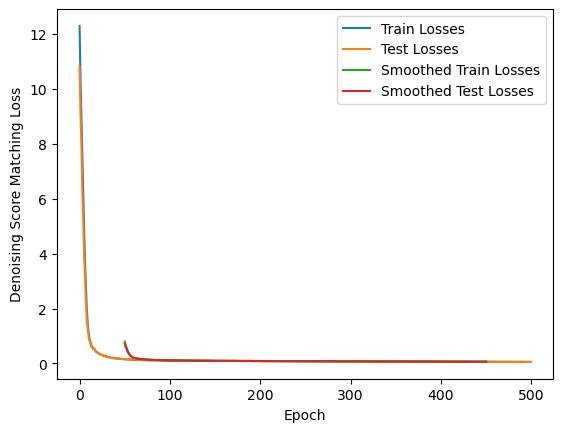

In [8]:
# Apply moving average filer to losses
window_size = 100
window = np.ones(window_size) / window_size
train_losses_f = np.convolve(train_losses, window, mode='valid')
test_losses_f = np.convolve(test_losses, window, mode='valid')

# Plot original losses
plt.plot(train_losses, label='Train Losses')
plt.plot(test_losses, label='Test Losses')

# Calculate the correct x positions for the smoothed losses
x_train_f = np.arange(window_size // 2, window_size // 2 + train_losses_f.shape[0])
x_test_f = np.arange(window_size // 2, window_size // 2 + test_losses_f.shape[0])

# Plot smoothed losses
plt.plot(x_train_f, train_losses_f, label='Smoothed Train Losses')
plt.plot(x_test_f, test_losses_f, label='Smoothed Test Losses')

# Adding labels and title
plt.xlabel('Epoch')  # Label for the x-axis
plt.ylabel('Denoising Score Matching Loss')  # Label for the y-axis

plt.legend()
plt.show()

## Sample from the model

In [9]:
def sample(params, key, num_samples):
    # Sample z from the prior distribution p(z) = N(0, I)
    z = jax.random.normal(key, shape=(num_samples, latent_dim))
    
    # Decode the samples to generate new data
    x = decoder.apply(params['decoder'], z)
    
    return x

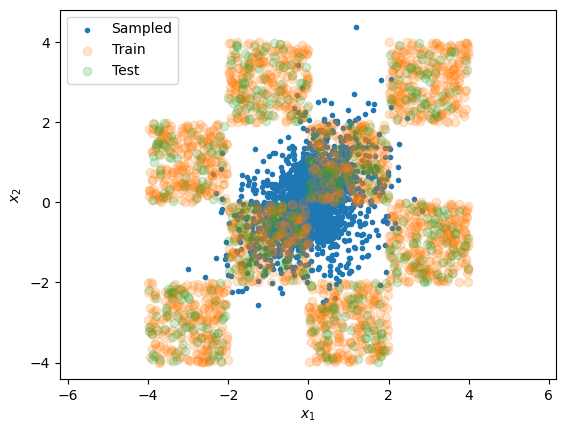

In [10]:
# Generate samples
samples = sample(
    params,
    next(prng_seq),
    2000)

# Plot samples
plt.scatter(samples[:, 0], samples[:, 1], marker='.', label='Sampled')
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2, marker='o', label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.2, marker='o', label='Test')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis('equal')
# plt.xlim([-4, 4])
# plt.ylim([-4, 4])
plt.legend()
plt.show() 